In [211]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

In [212]:
def read_solar_S_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        r_over_R = np.array(f['/r_over_R'])
        c_s = np.array(f['/c_s'])
        Gamma_1 = np.array(f['/Gamma_1'])
        T0 = np.array(f['/T'])
        rho0 = np.array(f['/rho'])
        p0 = np.array(f['/p'])
        
        r_over_R = np.flip(r_over_R)
        c_s = np.flip(c_s)
        Gamma_1 = np.flip(Gamma_1)
        T0 = np.flip(T0)
        rho0 = np.flip(rho0)
        p0 = np.flip(p0)

    return r_over_R, c_s, Gamma_1, T0, rho0, p0

r_over_R, c_s, Gamma_1, T0, rho0, p0\
    =read_solar_S_hdf5("../additional_files/solar_s.h5")

In [213]:
def read_solar_S_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        r = np.array(f['/r'])
        T0 = np.array(f['/T0'])
        rho0 = np.array(f['/rho0'])
        p0 = np.array(f['/p0'])
        g = np.array(f['/g'])
        s0 = np.array(f['/s0'])
        
    return r, T0, rho0, p0, g, s0

r_, T0_, rho0_, p0_, g_, s0_\
    =read_solar_S_hdf5("../data/solar_s_background_3.h5")

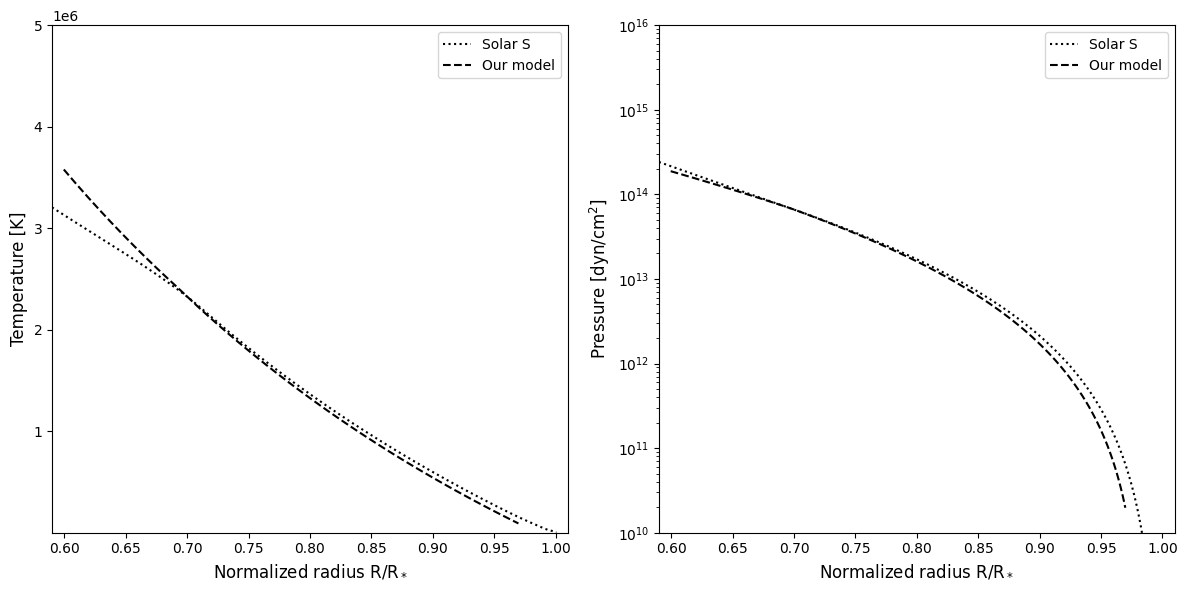

In [224]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].plot(r_over_R, T0, color="black", linestyle=":", label="Solar S")
ax[0].plot(r_/R_sun, T0_, color="black", linestyle="--", label="Our model")

ax[1].semilogy(r_over_R, p0, color="black", linestyle=":", label="Solar S")
ax[1].semilogy(r_/R_sun, p0_, color="black", linestyle="--", label="Our model")

ax[0].set_xlim(0.59,1.01)
ax[0].set_ylim(1e3,0.5e7)
ax[0].set_xlabel("Normalized radius R/R$_*$", fontsize=12)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
ax[0].legend()

ax[1].set_xlim(0.59,1.01)
ax[1].set_ylim(1e10, 1e16)
ax[1].set_xlabel("Normalized radius R/R$_*$", fontsize=12)
ax[1].set_ylabel("Pressure [dyn/cm$^2$]", fontsize=12)
ax[1].legend()

fig.tight_layout()
plt.show()

In [226]:
R_sun = 6.957e10
M_sun = 1.989e33
G = 6.6743e-8

M = 4*np.pi*R_sun**3 * cumtrapz(rho0*(r_over_R)**2, r_over_R, initial=0)
g = -G*M/((r_over_R*R_sun)**2)

/var/folders/k6/k6jkpmqs13l4qhz_xy4wzlmw0000gn/T/ipykernel_46388/103677430.py:6: RuntimeWarning: invalid value encountered in divide
  g = -G*M/((r_over_R*R_sun)**2)


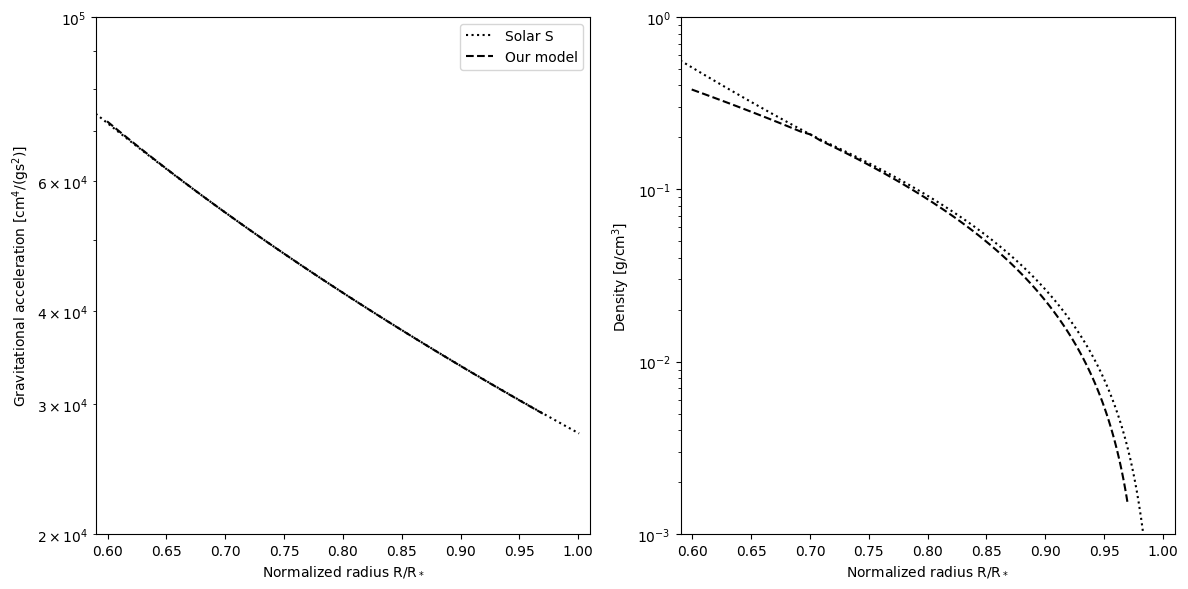

In [236]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].semilogy(r_over_R, np.abs(g), color="black", linestyle=":", label="Solar S")
ax[0].semilogy(r_/R_sun, np.abs(g_), color="black", linestyle="--", label="Our model")

ax[1].semilogy(r_over_R, rho0, color="black", linestyle=":", label="Solar S")
ax[1].semilogy(r_/R_sun, rho0_, color="black", linestyle="--", label="Our model")

ax[0].set_xlim(0.59,1.01)
ax[0].set_ylim(2e4,1e5)
ax[0].set_xlabel("Normalized radius R/R$_*$")
ax[0].set_ylabel("Gravitational acceleration [cm$^4$/(gs$^2$)]")
ax[0].legend()

ax[1].set_xlim(0.59,1.01)
ax[1].set_ylim(1e-3,0.1e1)
ax[1].set_xlabel("Normalized radius R/R$_*$")
ax[1].set_ylabel("Density [g/cm$^3$]")
ax[0].legend()

fig.tight_layout()
plt.show()

In [248]:
np.where(r_over_R>0.7)[0]

array([1046, 1047, 1048, ..., 2479, 2480, 2481])

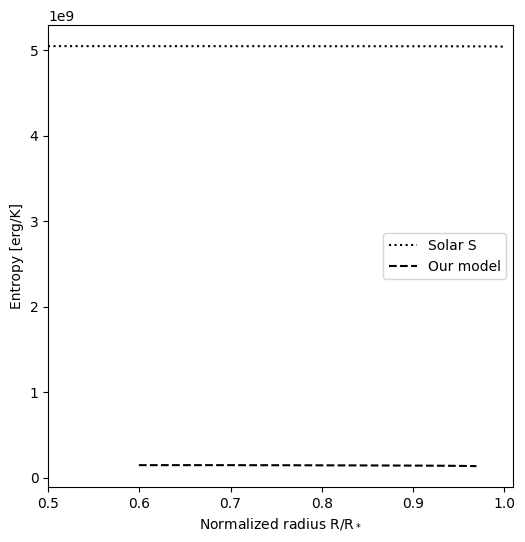

In [256]:
def k(r):
    # for now setting k as constant in radiative and convective zone
    if (r>=0.7*R_sun):
        return 0.001
    if r<0.7*R_sun:
        return 0

def get_nabla(r):
    nabla_ad = 0.4
    nabla_star = nabla_ad + k(r)
    return nabla_star, nabla_ad

gamma = 5/3

#Lantz after eq (10) 
r_star = P[0]/(rho0[0]*T0[0])
#Lantz after eq (72)
c_p = r_star/(1-1/Gamma_1[0])

s = np.zeros(len(T0))
s[0] = c_p*1e4

#entropy calculation
for i in range(0, len(T0)-1):
    dr = (r_over_R[i+1]-r_over_R[i])*R_sun
    
    H = - dr*p0[i+1]/(p0[i+1]-p0[i])
    #Lantz after eq (10) 
    r_star = p0[i+1]/(rho0[i+1]*T0[i+1])
    #Lantz after eq (72)
    c_p = r_star/(1-1/Gamma_1[i+1])
    nabla_star, nabla_ad = get_nabla(r_over_R[i+1]*R_sun)
    superad_param = nabla_star - nabla_ad
    
    ds_dr = - c_p/H * superad_param
    
    s[i+1] = s[i] + ds_dr * dr

fig, ax = plt.subplots(figsize=(6,6))

ax.plot(r_over_R, s, color="black", linestyle=":", label="Solar S")
ax.plot(r_/R_sun, s0_, color="black", linestyle="--", label="Our model")

ax.set_xlim(0.5,1.01)
ax.set_xlabel("Normalized radius R/R$_*$")
ax.set_ylabel("Entropy [erg/K]")
ax.legend()

plt.show()